In [372]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
import numpy as np
import scipy

### Analyze direct QA

In [345]:
def load_qa(filters=None):
    df = pd.read_json("results/qa_results.jsonl", lines=True)
    
    config_df = pd.json_normalize(df['config'])
    config_df.columns = ['config_' + col for col in config_df.columns]
    df = pd.concat([df, config_df], axis=1)

    df['options_str'] = df['options'].apply(str)

    df = df.sort_values('datetime', ascending=False).drop_duplicates(
        subset=['question', 'options_str', 'config_model_name'], keep='first')

    df['parsed_answer'] = df['parsed_model_response'].apply(lambda x: x.get('answer'))
    df = df[df['parsed_answer'].notna()]

    df['is_correct'] = df['parsed_answer'] == df['correct_idx']
    
    if filters:
        for col, val in filters.items():
            if val is None:
                df = df[df[col].isna()]
            else:
                df = df[df[col] == val]
    
    return df

In [346]:
filters = {
    # MODEL OPTIONS
    'config_model_name': "x-ai/grok-4-fast",
    # 'config_model_name': "openai/gpt-4o-mini",

    # DATASET OPTIONS
    # 'config_dataset_name': "Idavidrein/gpqa",
    # 'config_dataset_subset': "gpqa_diamond",
    # 'config_dataset_split': "train",

    'config_dataset_name': "TIGER-Lab/MMLU-Pro",
    'config_dataset_subset': None,
    'config_dataset_split': "test",

    # OTHER OPTIONS
    'config_random_seed': 42,
    'config_num_choices': 4,
}


In [347]:
df = load_qa(filters)

valid_df = df[df['parsed_answer'].notna()]
accuracy = valid_df['is_correct'].mean()
correct_count = valid_df['is_correct'].sum()
total_count = len(valid_df)

print(f"Accuracy: {accuracy:.2%}")
print(f"Correct: {correct_count}/{total_count}")

Accuracy: 92.00%
Correct: 92/100


### Analyze debate

In [348]:
def load_debate(debate_run_id):
    df = pd.read_json(f"results/debate/{debate_run_id}.jsonl", lines=True)
    config_df = pd.json_normalize(df['config'])
    config_df.columns = ['debate_' + col for col in config_df.columns]
    df = pd.concat([df, config_df], axis=1)
    df['options_str'] = df['options'].apply(str)
    return df

def load_verdict(verdict_run_id):
    df = pd.read_json(f"results/verdicts/{verdict_run_id}.jsonl", lines=True)
    config_df = pd.json_normalize(df['config'])
    config_df.columns = ['verdict_' + col for col in config_df.columns]
    df = pd.concat([df, config_df], axis=1)
    return df

def load_debate_and_verdict(verdict_run_id):
    verdict_df = load_verdict(verdict_run_id)
    debate_run_id = verdict_df['debate_run_id'].iloc[0]
    debate_df = load_debate(debate_run_id)
    
    df = debate_df.merge(verdict_df[['record_id', 'judge_verdict', 'verdict_judge_model']], on='record_id')
    df['parsed_answer'] = df['judge_verdict'].apply(lambda x: x.get('parsed', {}).get('answer'))
    df = df[df['parsed_answer'].notna()]
    df['is_correct_verdict'] = df['parsed_answer'] == df['correct_idx']
    
    return df

In [349]:
# run_id = 'ey2anfr'
run_id = 'hkpd1jy'

df = load_debate_and_verdict(run_id)

valid_df = df[df['parsed_answer'].notna()]
accuracy = valid_df['is_correct_verdict'].mean()
correct_count = valid_df['is_correct_verdict'].sum()
total_count = len(valid_df)

print(f"Accuracy: {accuracy:.2%}")
print(f"Correct: {correct_count}/{total_count}")

Accuracy: 87.50%
Correct: 14/16


### Compare QA and Debate

In [350]:
def load_debate_and_verdict_and_qa(verdict_run_id):
    df = load_debate_and_verdict(verdict_run_id)
    
    qa_df = load_qa(filters=None)
    qa_df = qa_df[['question', 'options_str', 'config_model_name', 'is_correct']]
    
    judge_qa = qa_df.rename(columns={'is_correct': 'is_correct_judge_qa'})
    df = df.merge(judge_qa, left_on=['question', 'options_str', 'verdict_judge_model'], 
                  right_on=['question', 'options_str', 'config_model_name'], how='left')
    
    debater_qa = qa_df.rename(columns={'is_correct': 'is_correct_debater_qa'})
    df = df.merge(debater_qa, left_on=['question', 'options_str', 'debate_debater_model'], 
                  right_on=['question', 'options_str', 'config_model_name'], how='left')
    
    df = df[df['is_correct_verdict'].notna() & df['is_correct_judge_qa'].notna() & df['is_correct_debater_qa'].notna()]
    
    return df

In [355]:
verdict_run_id = 'ntxteqy'

merged_df = load_debate_and_verdict_and_qa(verdict_run_id)

judge_qa = merged_df["is_correct_judge_qa"].mean().round(2) 
debater_qa = merged_df["is_correct_debater_qa"].mean().round(2)
debate_verdict = merged_df["is_correct_verdict"].mean().round(2)

print(f'Judge QA: {judge_qa} ({merged_df["is_correct_judge_qa"].sum()}/{merged_df["is_correct_judge_qa"].count()})')
print(f'Debater QA: {debater_qa} ({merged_df["is_correct_debater_qa"].sum()}/{merged_df["is_correct_debater_qa"].count()})')
print(f'Debate Verdict: {debate_verdict} ({merged_df["is_correct_verdict"].sum()}/{merged_df["is_correct_verdict"].count()})')

Judge QA: 0.74 (1048/1414)
Debater QA: 0.9 (1272/1414)
Debate Verdict: 0.72 (1019/1414)


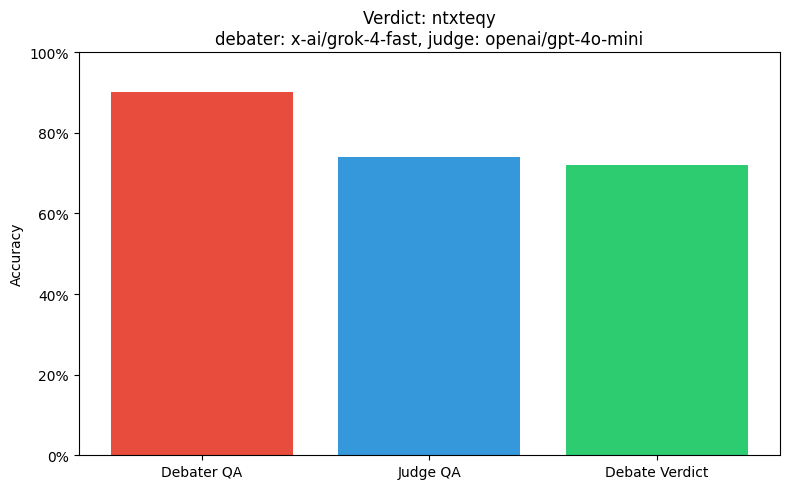

In [356]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(['Debater QA', 'Judge QA', 'Debate Verdict'], [debater_qa, judge_qa, debate_verdict], color=['#e74c3c', '#3498db', '#2ecc71'])
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
debater_model = merged_df['debate_debater_model'].iloc[0]
judge_model = merged_df['verdict_judge_model'].iloc[0]
plt.title(f'Verdict: {verdict_run_id}\ndebater: {debater_model}, judge: {judge_model}')
plt.tight_layout()
plt.show()

### Breakdown the results by category for MMLU-Pro

In [377]:
# From TIGER-Lab/MMLU-Pro, there's a column called "category"
# Add this column to the merged_df

verdict_run_id = '07e1puy'

merged_df = load_debate_and_verdict_and_qa(verdict_run_id)
mmlu_dataset = load_dataset('TIGER-Lab/MMLU-Pro')['test']

category_map = {}
for idx in range(len(mmlu_dataset)):
    category_map[idx] = mmlu_dataset[idx].get('category', None)
merged_df['category'] = merged_df['question_idx'].map(category_map)

print(merged_df['category'].value_counts())



Series([], Name: count, dtype: int64)


In [378]:
merged_df.head()

,run_id,record_id,datetime,config,prompt_template,question_idx,question,options,correct_idx,debate_history,...,options_str,judge_verdict,verdict_judge_model,parsed_answer,is_correct_verdict,config_model_name_x,is_correct_judge_qa,config_model_name_y,is_correct_debater_qa,category


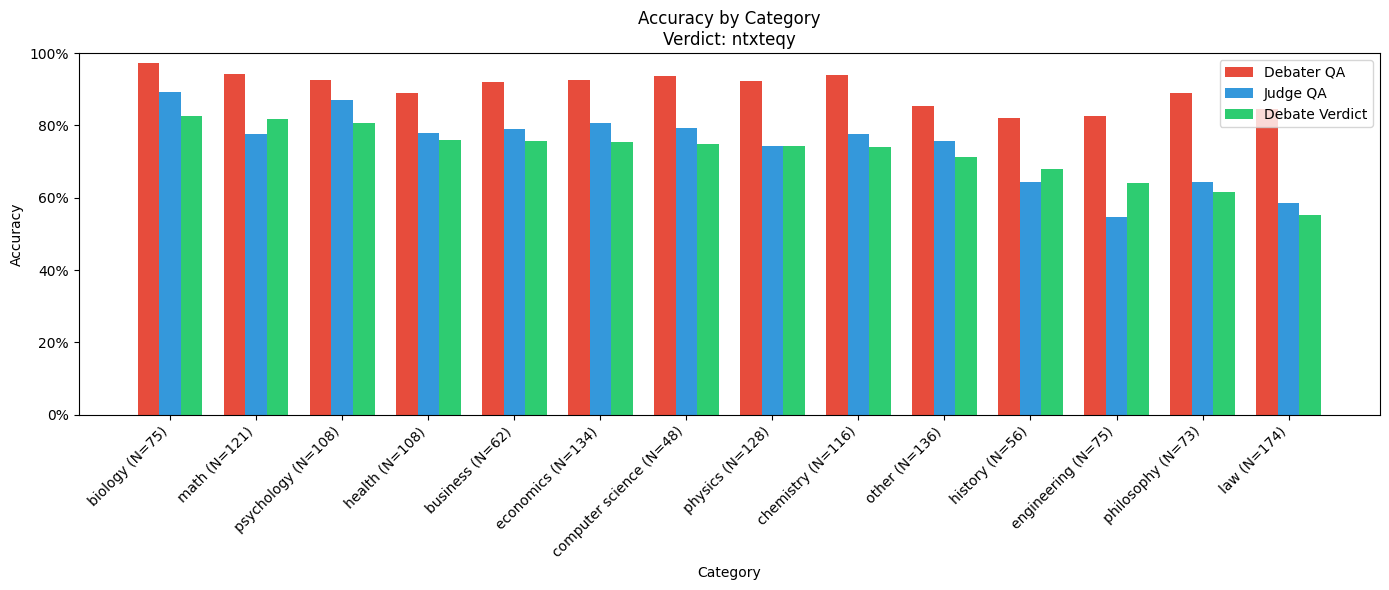


Category Results:
        category is_correct_debater_qa is_correct_judge_qa  is_correct_verdict  count
         biology              0.973333            0.893333            0.826667     75
            math              0.942149             0.77686            0.818182    121
      psychology              0.925926             0.87037            0.805556    108
          health              0.888889            0.777778            0.759259    108
        business              0.919355            0.790323            0.758065     62
       economics              0.925373             0.80597            0.753731    134
computer science                0.9375            0.791667            0.750000     48
         physics              0.921875            0.742188            0.742188    128
       chemistry              0.939655            0.775862            0.741379    116
           other              0.852941            0.757353            0.713235    136
         history              0.821

In [373]:
category_results = merged_df.groupby('category').agg({
    'is_correct_debater_qa': 'mean',
    'is_correct_judge_qa': 'mean',
    'is_correct_verdict': ['mean', 'count']
}).reset_index()

category_results.columns = ['category', 'is_correct_debater_qa', 'is_correct_judge_qa', 'is_correct_verdict', 'count']
category_results = category_results.sort_values('is_correct_verdict', ascending=False)

fig, ax = plt.subplots(figsize=(14, 6))

categories = category_results['category']
counts = category_results['count']
x = np.arange(len(categories))
width = 0.25

bars1 = ax.bar(x - width, category_results['is_correct_debater_qa'], width, label='Debater QA', color='#e74c3c')                                                                                                        
bars2 = ax.bar(x, category_results['is_correct_judge_qa'], width, label='Judge QA', color='#3498db')
bars3 = ax.bar(x + width, category_results['is_correct_verdict'], width, label='Debate Verdict', color='#2ecc71')                                                                                                       

ax.set_xlabel('Category')
ax.set_ylabel('Accuracy')
ax.set_title(f'Accuracy by Category\nVerdict: {verdict_run_id}')
ax.set_xticks(x)
category_labels = [f'{cat} (N={cnt})' for cat, cnt in zip(categories, counts)]
ax.set_xticklabels(category_labels, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.tight_layout()
plt.show()

print(f"\nCategory Results:")
print(category_results.to_string(index=False))

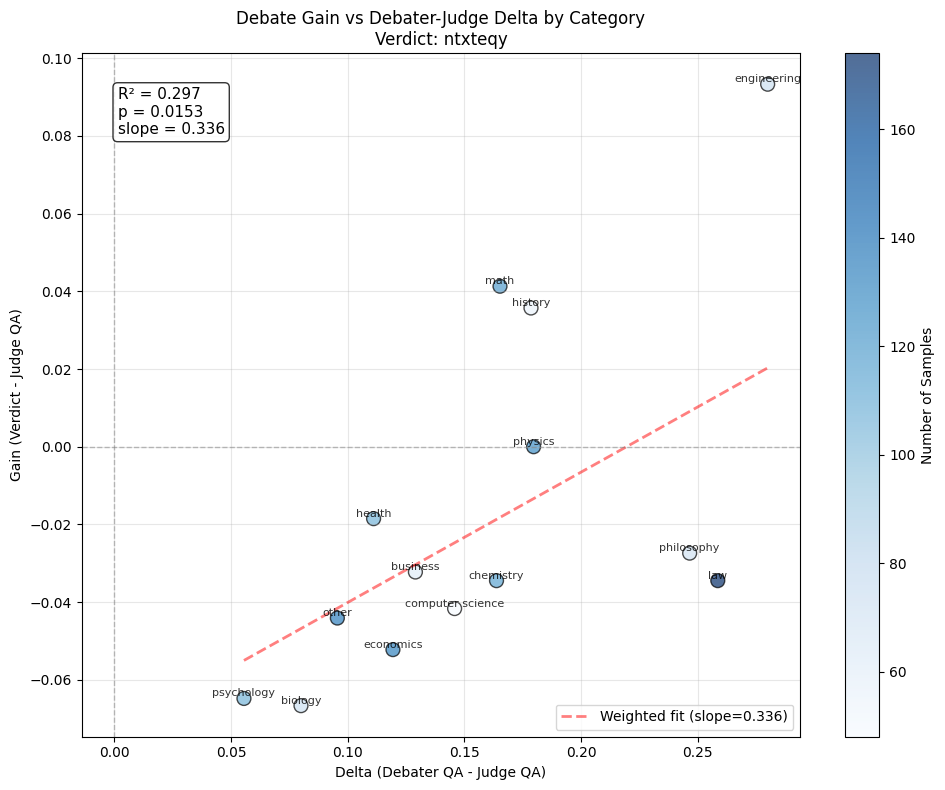


Scatter Plot Data:
        category    delta      gain  count
         biology 0.080000 -0.066667     75
            math 0.165289  0.041322    121
      psychology 0.055556 -0.064815    108
          health 0.111111 -0.018519    108
        business 0.129032 -0.032258     62
       economics 0.119403 -0.052239    134
computer science 0.145833 -0.041667     48
         physics 0.179688  0.000000    128
       chemistry 0.163793 -0.034483    116
           other 0.095588 -0.044118    136
         history 0.178571  0.035714     56
     engineering 0.280000  0.093333     75
      philosophy 0.246575 -0.027397     73
             law 0.258621 -0.034483    174


In [376]:
category_results['delta'] = category_results['is_correct_debater_qa'].astype(float) - category_results['is_correct_judge_qa'].astype(float)
category_results['gain'] = category_results['is_correct_verdict'].astype(float) - category_results['is_correct_judge_qa'].astype(float)

from scipy import stats
from sklearn.linear_model import LinearRegression

x = category_results['delta'].values.astype(float)
y = category_results['gain'].values.astype(float)
weights = category_results['count'].values.astype(float)

model = LinearRegression()
model.fit(x.reshape(-1, 1), y, sample_weight=weights)
slope = model.coef_[0]
intercept = model.intercept_

y_pred = model.predict(x.reshape(-1, 1))
ss_res = np.sum(weights * (y - y_pred)**2)
ss_tot = np.sum(weights * (y - np.average(y, weights=weights))**2)
r_squared = 1 - (ss_res / ss_tot)

pearson_r, p_value = stats.pearsonr(x, y)

fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(category_results['delta'], category_results['gain'], 
                     c=category_results['count'], s=100, cmap='Blues', alpha=0.7, edgecolors='black')

x_line = np.linspace(x.min(), x.max(), 100)
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, 'r--', linewidth=2, alpha=0.5, label=f'Weighted fit (slope={slope:.3f})')

for i, row in category_results.iterrows():
    ax.annotate(row['category'], (row['delta'], row['gain']), 
                fontsize=8, ha='center', va='bottom', alpha=0.8)

ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

stats_text = f'R² = {r_squared:.3f}\np = {p_value:.4f}\nslope = {slope:.3f}'
ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.set_xlabel('Delta (Debater QA - Judge QA)')
ax.set_ylabel('Gain (Verdict - Judge QA)')
ax.set_title(f'Debate Gain vs Debater-Judge Delta by Category\nVerdict: {verdict_run_id}')
ax.grid(True, alpha=0.3)
ax.legend()

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Number of Samples')

plt.tight_layout()
plt.show()

print("\nScatter Plot Data:")
print(category_results[['category', 'delta', 'gain', 'count']].to_string(index=False))


### Analyze token usage in the debate run

In [353]:
run_id = 'dcg8y0b'

debate_df = load_debate(run_id)

record_ids = []
completion_tokens_used_per_debate = []
reasoning_tokens_used_per_debate = []
for i, row in debate_df.iterrows():
    record_ids.append(row['record_id'])
    debate_history = row['debate_history']
    completion_tokens_used_this_debate, reasoning_tokens_used_this_debate = 0, 0
    for turn in debate_history:
        completion_tokens_used_this_debate += turn['token_usage']['completion_tokens']
        if 'completion_tokens_details' in turn['token_usage'] and turn['token_usage']['completion_tokens_details'] is not None:
            reasoning_tokens_used_this_debate += turn['token_usage']['completion_tokens_details']['reasoning_tokens']
        else:
            reasoning_tokens_used_this_debate += 0
    completion_tokens_used_per_debate.append(completion_tokens_used_this_debate)
    reasoning_tokens_used_per_debate.append(reasoning_tokens_used_this_debate)

print(record_ids)
print(f"completion_tokens_used_per_debate: {completion_tokens_used_per_debate}")
print(f"reasoning_tokens_used_per_debate: {reasoning_tokens_used_per_debate}")


['uopkylg', '0g649bb', 'dn0srf9', 'pvy2pz2', 'z6cpl1k', 'fhpjpo6', 'ug10m7x', 'i4kch6d', 'dezmdd2', 'jw0dpuy', 'qs23z34', 'uy2xyzr', 'sq9cqvp', 'cgttxpu', 'ftrrg0m', 'os7f0j8']
completion_tokens_used_per_debate: [2449, 2630, 2459, 2581, 2982, 3107, 3925, 2791, 5296, 8696, 13599, 14033, 17834, 18264, 20398, 15979]
reasoning_tokens_used_per_debate: [1385, 1538, 1373, 1445, 1919, 1937, 2696, 1701, 3874, 7343, 12072, 12755, 16497, 16887, 18834, 15049]


In [354]:
import numpy as np
print(np.sum(completion_tokens_used_per_debate))
print(np.sum(reasoning_tokens_used_per_debate))


137023
117305
